# *contents*

- 加载数据
- 历史夏普比率
- 不同时间窗口的夏普比率

In [1]:
%matplotlib inline
import logging
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import helper
import pprint
import log_setup

helper.chinese_font_setup()
log_setup.setup()

In [2]:
datainfo, datainfo_abbr = helper.datafiles_info_v2()
datainfo

{'510050.SH': DataInfo(code='510050.SH', name='上证50ETF', abbr='SZ50ETF,', path='./datafiles/510050.SH_2005-02-23_2023-04-25.xlsx', first='2005-02-23', last='2023-04-25'),
 '510300.SH': DataInfo(code='510300.SH', name='沪深300ETF', abbr='HS300ETF,', path='./datafiles/510300.SH_2012-05-28_2023-04-25.xlsx', first='2012-05-28', last='2023-04-25'),
 '510500.SH': DataInfo(code='510500.SH', name='中证500ETF', abbr='ZZ500ETF,', path='./datafiles/510500.SH_2013-03-15_2023-04-25.xlsx', first='2013-03-15', last='2023-04-25'),
 '159915.SZ': DataInfo(code='159915.SZ', name='创业板ETF', abbr='CYBETF,', path='./datafiles/159915.SZ_2011-12-09_2023-04-25.xlsx', first='2011-12-09', last='2023-04-25'),
 '159949.SZ': DataInfo(code='159949.SZ', name='创业板50ETF', abbr='CYB50ETF,', path='./datafiles/159949.SZ_2016-07-22_2023-04-25.xlsx', first='2016-07-22', last='2023-04-25'),
 '588000.SH': DataInfo(code='588000.SH', name='科创50ETF', abbr='KC50ETF,', path='./datafiles/588000.SH_2020-11-16_2023-04-25.xlsx', first='202

In [3]:
def build_big_df():
    series = []
    keys = []
    for di in datainfo.values():
        df = pd.read_excel(di.path, header=0, index_col=0)
        logging.info('{} {}'.format(di.name, df.shape))
        keys.append(di.code)
        series.append(df.close)
    df = pd.concat(series, axis=1, keys=keys)
    logging.info('result df shape: {}'.format(df.shape))
    return df

df = build_big_df()
df.describe()

[2023-04-27 23:50:21,212] [INFO]	[1009832064.py:6:build_big_df] 上证50ETF (4420, 7)
[2023-04-27 23:50:21,576] [INFO]	[1009832064.py:6:build_big_df] 沪深300ETF (2655, 7)
[2023-04-27 23:50:21,888] [INFO]	[1009832064.py:6:build_big_df] 中证500ETF (2459, 7)
[2023-04-27 23:50:22,209] [INFO]	[1009832064.py:6:build_big_df] 创业板ETF (2763, 7)
[2023-04-27 23:50:22,423] [INFO]	[1009832064.py:6:build_big_df] 创业板50ETF (1643, 7)
[2023-04-27 23:50:22,564] [INFO]	[1009832064.py:6:build_big_df] 科创50ETF (594, 7)
[2023-04-27 23:50:22,843] [INFO]	[1009832064.py:6:build_big_df] 黄金ETF (2372, 7)
[2023-04-27 23:50:22,914] [INFO]	[1009832064.py:6:build_big_df] 双创50ETF (440, 7)
[2023-04-27 23:50:22,976] [INFO]	[1009832064.py:6:build_big_df] A50ETF (357, 7)
[2023-04-27 23:50:22,992] [INFO]	[1009832064.py:10:build_big_df] result df shape: (4420, 9)


,510050.SH,510300.SH,510500.SH,159915.SZ,159949.SZ,588000.SH,518880.SH,159781.SZ,159601.SZ
count,4420.000000,2655.000000,2459.000000,2763.000000,1643.000000,594.000000,2372.000000,440.000000,357.000000
mean,2.017500,3.362446,5.382457,1.852079,0.898278,1.269764,3.053285,0.712639,0.865006
std,0.762775,0.931155,1.199667,0.704466,0.303249,0.198064,0.584696,0.120683,0.070014
min,0.517918,1.813988,2.819713,0.598000,0.425000,0.909000,2.167000,0.534000,0.721000
25%,1.446302,2.777259,4.621834,1.356000,0.658000,1.078000,2.616000,0.616000,0.811000
50%,1.983732,3.428157,5.610480,1.761000,0.814000,1.267500,2.774000,0.663500,0.851000
75%,2.656780,3.953988,6.175000,2.354500,1.114000,1.432500,3.653000,0.843000,0.907000
max,3.905555,5.629466,10.218341,3.790000,1.585000,1.670000,4.378000,0.994000,1.036000


<Axes: title={'center': '收盘价 (扩缩股、分红调整后)'}, ylabel='Adjusted Close'>

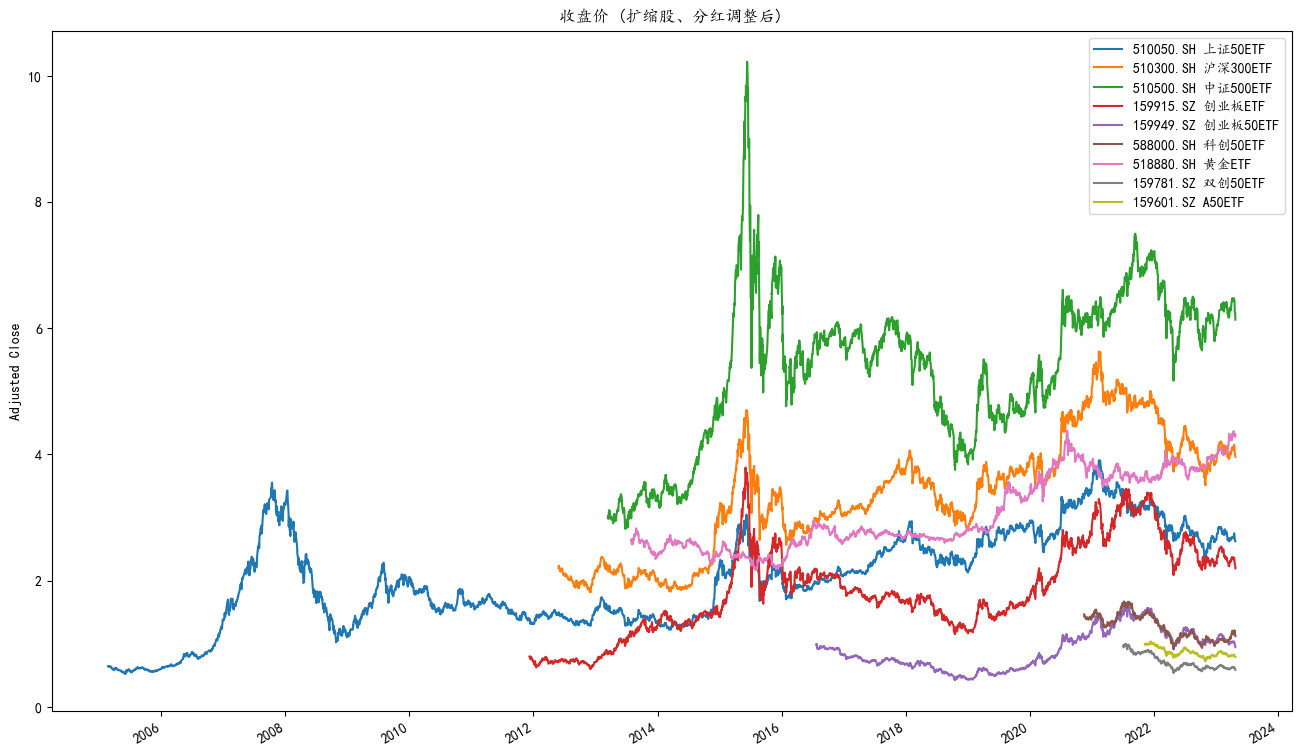

In [4]:
df.rename(
    columns=dict([ (di.code, '{} {}'.format(di.code, di.name)) for di in datainfo.values() ])
).plot(figsize=(16,10), ylabel='Adjusted Close', title='收盘价 (扩缩股、分红调整后)')

# *历史夏普比率*

此处 <font color=red>假设无风险利率为2%</font>。

In [5]:
k_annual_risk_free_rate = 0.02
k_days_per_year = 252

In [6]:
def historical_sharpe_ratio(df, annual_risk_free_rate=k_annual_risk_free_rate):
    print('历史夏普比率')
    for code in df.columns:
        price = df[code]
        daily_ret = price.pct_change()
        daily_excess_ret = daily_ret - annual_risk_free_rate / k_days_per_year
        sharpe_ratio = daily_excess_ret.mean() / daily_excess_ret.std() * np.sqrt(k_days_per_year)
        print('{} {}:\t{:8.5f}'.format(code, datainfo[code].name, sharpe_ratio))
historical_sharpe_ratio(df, k_annual_risk_free_rate)

历史夏普比率
510050.SH 上证50ETF:	 0.35901
510300.SH 沪深300ETF:	 0.27036
510500.SH 中证500ETF:	 0.33037
159915.SZ 创业板ETF:	 0.38474
159949.SZ 创业板50ETF:	 0.05036
588000.SH 科创50ETF:	-0.41740
518880.SH 黄金ETF:	 0.31662
159781.SZ 双创50ETF:	-1.12497
159601.SZ A50ETF:	-0.84770


# *不同滑动时间窗口的夏普比率*

In [7]:
k_rolling_window = 121 # half year

def annualized_sharpe_ratio(rolling_window=k_rolling_window,
                            annual_risk_free_rate=k_annual_risk_free_rate):
    daily_excess_return = df.pct_change() - annual_risk_free_rate / k_days_per_year
    df_mean = daily_excess_return.rolling(window=rolling_window).mean()
    df_std  = daily_excess_return.rolling(window=rolling_window).std()
    rolling_annual_sharpe_ratio = df_mean / df_std * np.sqrt(k_days_per_year)

    rolling_annual_sharpe_ratio.rename(
        columns=dict([ (di.code, '{} {}'.format(di.code, di.name)) for di in datainfo.values() ]),
        inplace=True)
    rolling_annual_sharpe_ratio.plot(figsize=(16,9), ylabel='Annualized Sharpe Ratio',
                                     title='年化夏普比率 ( 滑动窗口 = {}日, 无风险利率 $r_F$ = {:.2f} % )'.format(
                                         rolling_window, annual_risk_free_rate*100))
    return rolling_annual_sharpe_ratio

## 滑动窗口 0.25 year

,510050.SH 上证50ETF,510300.SH 沪深300ETF,510500.SH 中证500ETF,159915.SZ 创业板ETF,159949.SZ 创业板50ETF,588000.SH 科创50ETF,518880.SH 黄金ETF,159781.SZ 双创50ETF,159601.SZ A50ETF
count,4357.000000,2592.000000,2397.000000,2701.000000,1580.000000,531.000000,2309.000000,377.000000,294.000000
mean,0.518909,0.477742,0.567768,0.438013,0.036954,-0.489350,0.165035,-0.932026,-0.709502
std,2.191909,2.009772,2.086526,2.032247,2.140047,2.050640,1.835015,1.734953,1.913261
min,-5.120980,-4.996159,-4.237648,-4.719776,-4.877110,-5.887404,-5.695250,-4.911839,-4.785614
25%,-1.143045,-0.985897,-0.884317,-0.904825,-1.651160,-1.778669,-1.149442,-2.020678,-2.240725
50%,0.286266,0.291846,0.296483,0.338279,0.034181,-0.699297,0.030870,-0.737863,-0.730165
75%,2.041935,1.883461,1.714349,1.713096,1.456154,0.706649,1.567276,0.206026,0.981556
max,8.202237,6.329261,8.219895,6.781857,7.152687,4.261087,5.191737,3.419330,3.822962


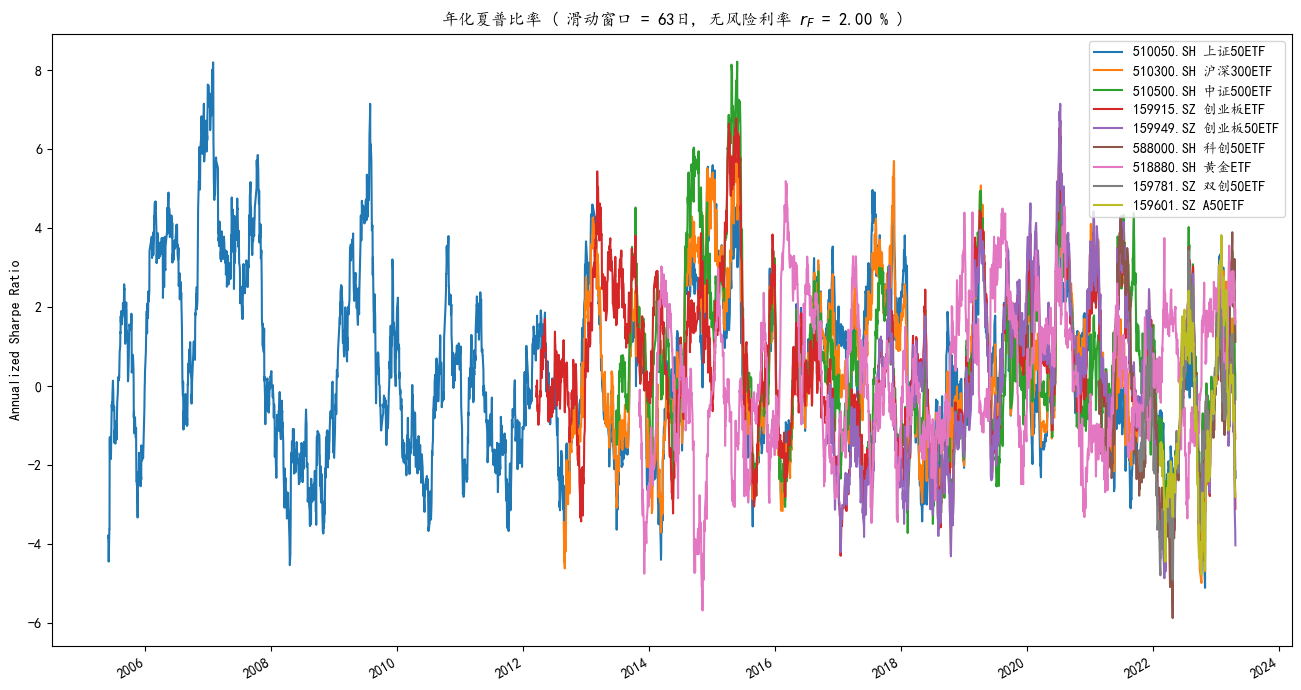

In [8]:
annualized_sharpe_ratio(rolling_window=k_days_per_year//4).describe()

## 滑动窗口 0.5 year

,510050.SH 上证50ETF,510300.SH 沪深300ETF,510500.SH 中证500ETF,159915.SZ 创业板ETF,159949.SZ 创业板50ETF,588000.SH 科创50ETF,518880.SH 黄金ETF,159781.SZ 双创50ETF,159601.SZ A50ETF
count,4294.000000,2529.000000,2334.000000,2638.000000,1517.000000,468.000000,2246.000000,314.000000,231.000000
mean,0.479192,0.408210,0.441159,0.387492,0.047652,-0.518064,0.235374,-1.058357,-0.631895
std,1.678216,1.425707,1.404802,1.394222,1.480100,1.249932,1.177227,1.061544,0.453991
min,-3.054687,-2.678581,-3.198336,-3.059749,-3.070583,-3.573616,-3.185736,-3.527437,-1.764458
25%,-0.813924,-0.690332,-0.473617,-0.549352,-1.055968,-1.402275,-0.630405,-1.876612,-0.888328
50%,0.237405,0.251577,0.386001,0.309911,-0.055924,-0.531966,0.066802,-0.952414,-0.588697
75%,1.586420,1.272567,1.155770,1.368673,1.306163,0.646537,1.115881,-0.312659,-0.351830
max,5.535773,4.568122,5.487546,4.892639,3.372235,2.254052,3.189685,1.353691,0.548093


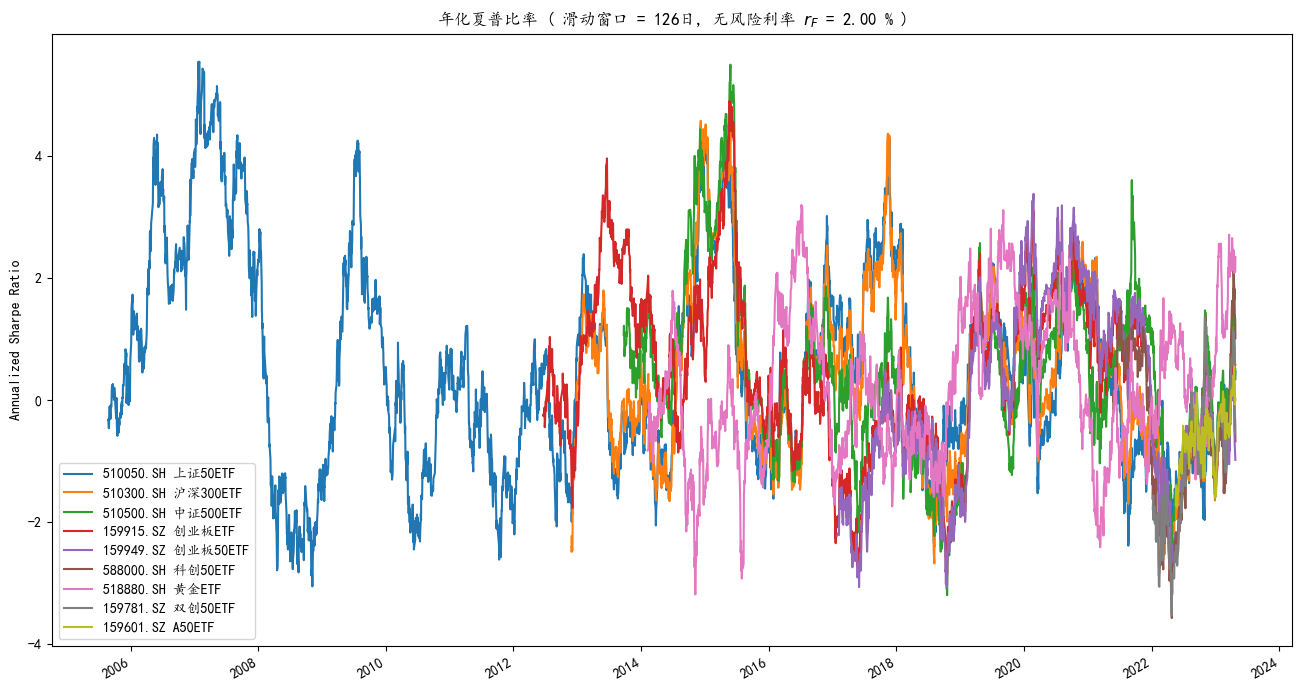

In [9]:
annualized_sharpe_ratio(rolling_window=k_days_per_year//2).describe()

## 滑动窗口 1 year

,510050.SH 上证50ETF,510300.SH 沪深300ETF,510500.SH 中证500ETF,159915.SZ 创业板ETF,159949.SZ 创业板50ETF,588000.SH 科创50ETF,518880.SH 黄金ETF,159781.SZ 双创50ETF,159601.SZ A50ETF
count,4168.000000,2403.000000,2208.000000,2512.000000,1391.000000,342.000000,2120.000000,188.000000,105.000000
mean,0.459604,0.364814,0.362550,0.423376,0.168771,-0.795637,0.231845,-0.983401,-0.641050
std,1.306786,1.020266,1.022376,1.069723,1.205150,0.516094,0.825984,0.393098,0.302013
min,-2.478819,-1.694298,-2.169755,-1.888813,-1.866516,-1.624519,-1.500227,-1.536341,-1.231557
25%,-0.519676,-0.465243,-0.286713,-0.521427,-0.851315,-1.219099,-0.463183,-1.300300,-0.901291
50%,0.192600,0.283029,0.248725,0.555878,-0.282580,-0.877444,0.181276,-1.161540,-0.580210
75%,1.134914,1.096639,0.963114,1.303211,1.210584,-0.513597,0.817048,-0.609295,-0.423242
max,4.350246,3.546251,4.631038,3.549088,2.658163,0.526291,2.553071,-0.085313,0.000831


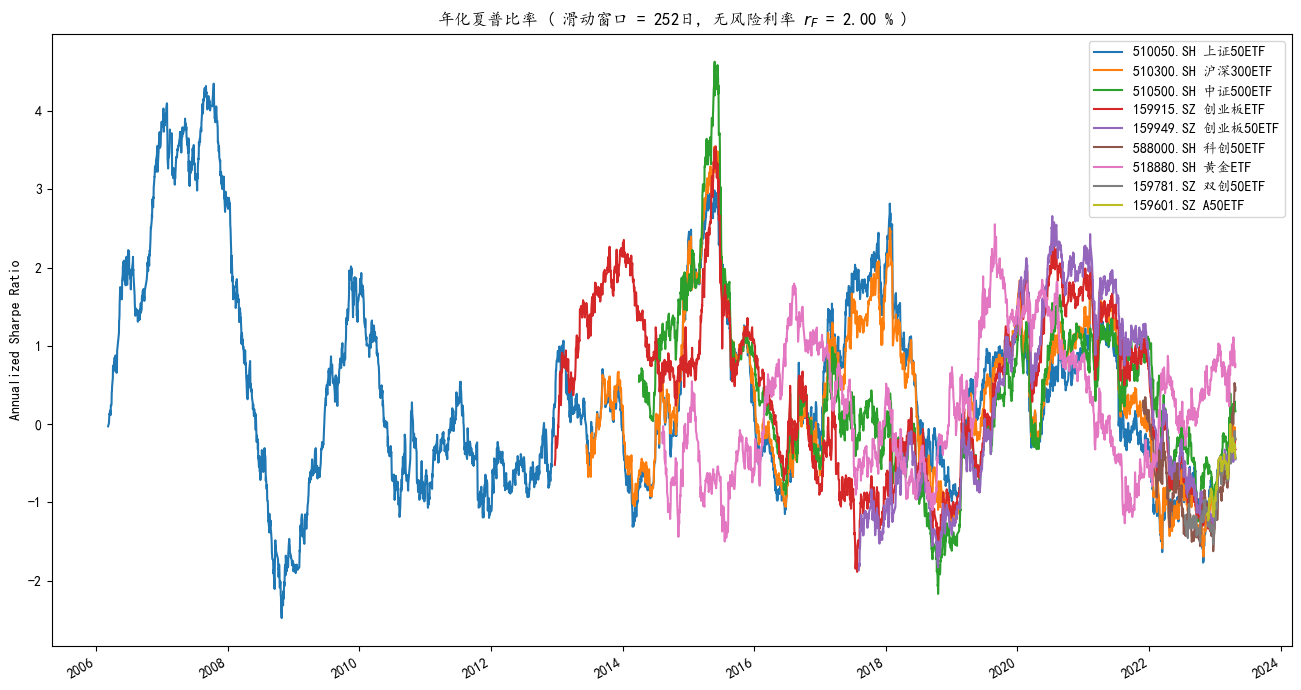

In [10]:
annualized_sharpe_ratio(rolling_window=k_days_per_year).describe()

## 滑动窗口 2 year

,510050.SH 上证50ETF,510300.SH 沪深300ETF,510500.SH 中证500ETF,159915.SZ 创业板ETF,159949.SZ 创业板50ETF,588000.SH 科创50ETF,518880.SH 黄金ETF,159781.SZ 双创50ETF,159601.SZ A50ETF
count,3916.000000,2151.000000,1956.000000,2260.000000,1139.000000,90.000000,1868.000000,0.0,0.0
mean,0.384564,0.399198,0.280600,0.459626,0.394549,-0.505295,0.325325,NaN,NaN
std,0.814971,0.497721,0.652590,0.776405,0.925011,0.194278,0.516050,NaN,NaN
min,-1.022764,-0.955966,-1.175844,-1.306770,-1.521888,-0.764575,-0.790675,NaN,NaN
25%,-0.178913,0.084919,-0.208711,-0.172875,-0.309647,-0.632662,-0.030481,NaN,NaN
50%,0.259581,0.423682,0.293088,0.525985,0.306280,-0.573484,0.285544,NaN,NaN
75%,0.688691,0.725319,0.742355,1.122518,1.258789,-0.458575,0.707341,NaN,NaN
max,3.201387,1.709075,2.545016,2.211638,1.998511,-0.032109,1.654967,NaN,NaN


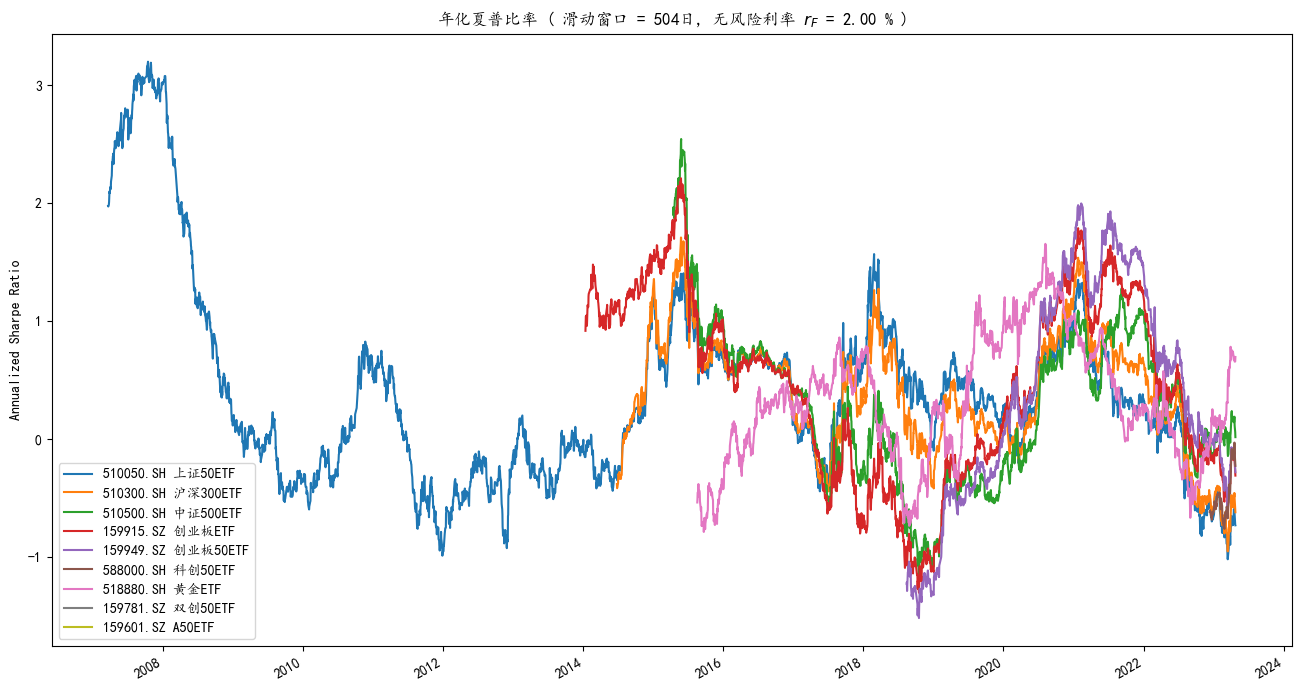

In [11]:
annualized_sharpe_ratio(rolling_window=k_days_per_year*2).describe()

## 滑动窗口 3 year

,510050.SH 上证50ETF,510300.SH 沪深300ETF,510500.SH 中证500ETF,159915.SZ 创业板ETF,159949.SZ 创业板50ETF,588000.SH 科创50ETF,518880.SH 黄金ETF,159781.SZ 双创50ETF,159601.SZ A50ETF
count,3664.000000,1899.000000,1704.000000,2008.000000,887.000000,0.0,1616.000000,0.0,0.0
mean,0.294780,0.389078,0.223011,0.448083,0.586090,NaN,0.418118,NaN,NaN
std,0.450815,0.261670,0.402894,0.553179,0.493762,NaN,0.263089,NaN,NaN
min,-0.722680,-0.398448,-0.790261,-0.915528,-0.649325,NaN,-0.149616,NaN,NaN
25%,-0.095196,0.250279,-0.124657,0.163222,0.385514,NaN,0.198647,NaN,NaN
50%,0.376355,0.425769,0.282919,0.498476,0.675928,NaN,0.392847,NaN,NaN
75%,0.621669,0.587194,0.583296,0.815629,0.942560,NaN,0.645589,NaN,NaN
max,1.616234,0.845436,0.978415,1.948189,1.454608,NaN,1.186193,NaN,NaN


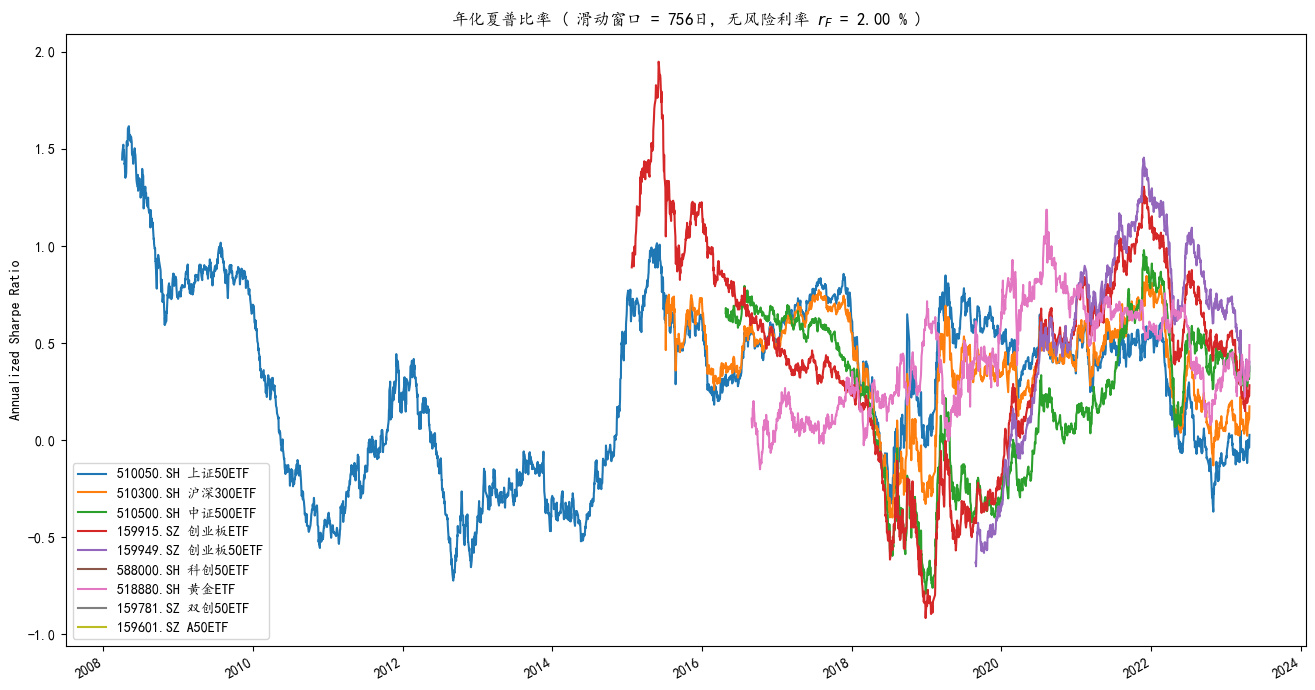

In [12]:
annualized_sharpe_ratio(rolling_window=k_days_per_year*3).describe()

## 滑动窗口 5 year

,510050.SH 上证50ETF,510300.SH 沪深300ETF,510500.SH 中证500ETF,159915.SZ 创业板ETF,159949.SZ 创业板50ETF,588000.SH 科创50ETF,518880.SH 黄金ETF,159781.SZ 双创50ETF,159601.SZ A50ETF
count,3160.000000,1395.000000,1200.000000,1504.000000,383.000000,0.0,1112.000000,0.0,0.0
mean,0.288302,0.373514,0.156189,0.323395,0.351057,NaN,0.411329,NaN,NaN
std,0.295058,0.170101,0.130113,0.167325,0.055583,NaN,0.215840,NaN,NaN
min,-0.501934,-0.002842,-0.208011,-0.075349,0.189154,NaN,-0.166603,NaN,NaN
25%,0.094484,0.258108,0.059454,0.200380,0.312923,NaN,0.315161,NaN,NaN
50%,0.336110,0.416745,0.163341,0.295085,0.356893,NaN,0.424519,NaN,NaN
75%,0.519209,0.507366,0.238542,0.409942,0.392821,NaN,0.547928,NaN,NaN
max,0.785808,0.681282,0.500977,0.704254,0.449381,NaN,0.856698,NaN,NaN


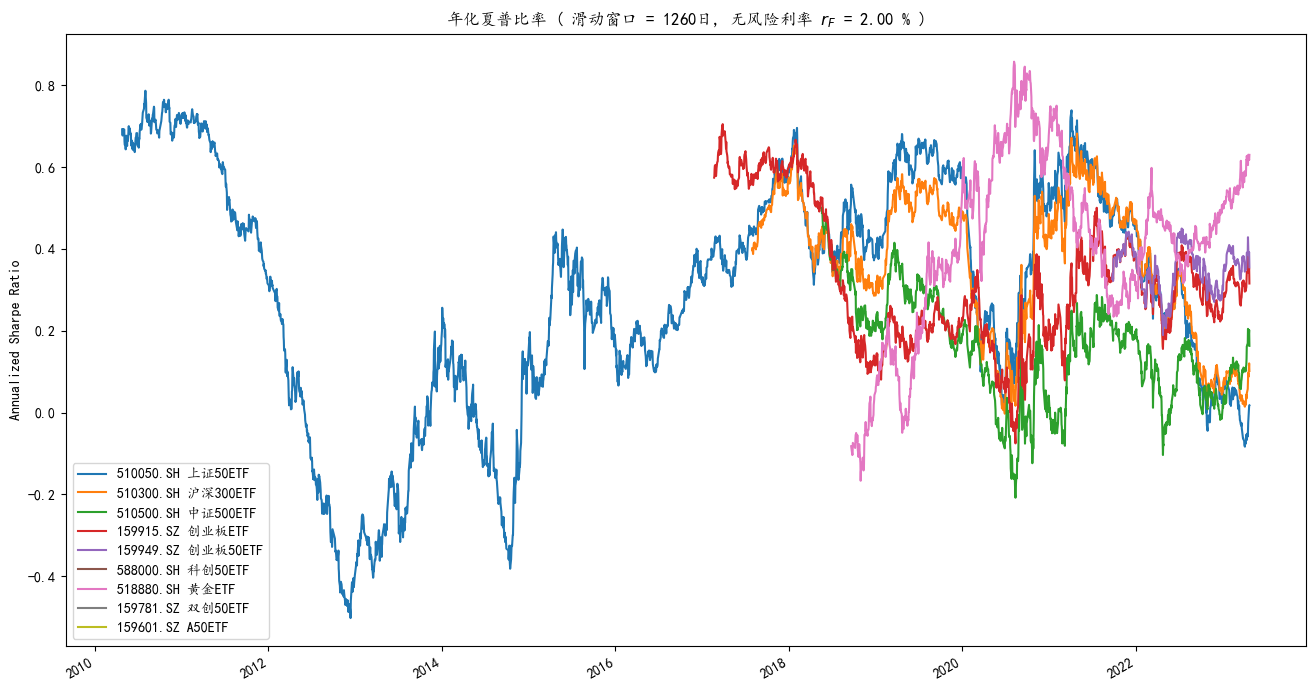

In [13]:
annualized_sharpe_ratio(rolling_window=k_days_per_year*5).describe()